# 去燥自动编码器
标准自动编码器和稀疏自动编码器属于欠完备自动编码器，因为隐藏层的维度比输入（输出）层低。去噪自编码器属于过完备自编码器，隐藏层的维数大于输入层时效果会更好。  
  
去噪自编码器从受损（噪声）输入中学习，它向编码器网络提供有噪声的输入，然后将解码器的重构图像与原始输入进行比较，这就能“教会”网络去学习如何对输入去噪。不再只是进行像素比较，为了去噪，它也会学习相邻像素的信息。
  
去噪自编码器也具有 $KL$ 散度惩罚项，它不同于稀疏自编码器的主要有两个方面，首先，隐藏层的单元数 $n_{hidden}$ 大于输入层的单元数 $m$，即 $n_{hidden} > m$ ；其次，编码器的输入是受损输入，要做到这一点，需要定义了一个给输入添加噪声的受损函数

In [1]:
def corrupt_img(x, noise_factor=0.3):
    noisy_imgs = x + noise_factor * np.random.randn(*x.shape)
    noisy_imgs = np.clip(noisy_imgs, 0., 1.)
    return noisy_imgs

## 实例：利用MNIST数据集训练去燥自动编码器，并使用它对测试图像去燥和重构

1. 导入模块

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import math
%matplotlib inline

2. 加载 MNIST 数据集

In [3]:
mnist = input_data.read_data_sets('MNIST_data')
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


3. 定义类 DenoisingAutoEncoder，与前面的 SparseAutoEncoder 类相似。在这里，定义一个受噪声影响的图像的占位符，将这个噪声图像送入编码器；重构误差是原始清晰图像和解码器输出之间的差异，这里保留了稀疏惩罚项，因此，fit 函数参数包括原始图像和噪声图像

`这种去燥相当于有监督去燥（学习）`

In [4]:
class DenoisingAutoEncoder:
    """去燥自编码器"""
        
    def __init__(self, m, n, eta=0.01):
        """
        m：输入输出层神经元数
        n：隐藏层神经元数
        """
        self._m = m
        self._n = n
        self.learning_rate = eta
        self.session = None
        
        # 构建计算图
        
        # 权重与偏置
        self._W1 = tf.Variable(tf.random_normal(shape=(self._m, self._n)))
        self._W2 = tf.Variable(tf.random_normal(shape=(self._n, self._m)))
        self._b1 = tf.Variable(np.zeros(self._n).astype(np.float32))    # 隐藏层偏置
        self._b2 = tf.Variable(np.zeros(self._m).astype(np.float32))    # 输出层偏置
        
        # 输入层占位符
        self._X = tf.placeholder(dtype='float', shape=[None, self._m])        # 原始图像
#         self._X_noisy = tf.placeholder(dtype='float', shape=[None, self._m])  # 外部加燥图像
        self._X_noisy = self.corrupt(self._X) * 0.3 + self._X * (1 - 0.3)     # 内部加燥图像
        
        # 编码器
        self.y = self.encoder(self._X_noisy)
        
        # 解码器
        self.r = self.decoder(self.y)
        
        # 解码误差
        error = self._X - self.r
        
        # 损失函数
        self._loss = tf.reduce_mean(tf.pow(error, 2))   # MSE
        alpha = 5e-2
        kl_div_loss = tf.reduce_sum(self.kl_div(0.02, tf.reduce_mean(self.y, 0)))   # 由KL散度定义的稀疏参数正则项
        loss = self._loss + alpha * kl_div_loss   # MSE + 系数参数正则项
        
        # 优化算法
        self._opt = tf.train.AdamOptimizer(self.learning_rate).minimize(loss)
        
    def logfunc(self, x1, x2):
        """对数运算"""
        return tf.multiply(x1, tf.log(tf.div(x1, x2)))
    
    def kl_div(self, rho, rho_hat):
        """计算KL散度"""
        term2_num = tf.constant(1.) - rho
        term2_den = tf.constant(1.) - rho_hat
        kl = self.logfunc(rho, rho_hat) + self.logfunc(term2_num, term2_den)
        return kl
        
    def encoder(self, x):
        """编码器"""
        h = tf.matmul(x, self._W1) + self._b1
        return tf.nn.sigmoid(h)
    
    def decoder(self, x):
        """解码器"""
        h = tf.matmul(x, self._W2) + self._b2
        return tf.nn.sigmoid(h)
    
    def corrupt(self, x):
        return x * tf.cast(tf.random.uniform(shape=tf.shape(x), minval=0, maxval=2), dtype=tf.float32)
    
    def get_weights(self):
        return self.session.run([self._W1, self._W2, self._b1, self._b2])
    
    def set_session(self, session):
        """开启会话"""
        self.session = session
        
    def reduced_dimension(self, x):
        """降维"""
        h = self.encoder(x)
        return self.session.run(h, feed_dict={self._X: x})
    
    def reconstruct(self, x):
        """重构"""
        h = self.encoder(x)
        r = self.decoder(h)
        return self.session.run(r, feed_dict={self._X: x})
    
    def fit(self, X, epochs=1, batch_size=100):
        N, D = X.shape
        num_batches = N // batch_size
        obj = []
        for i in range(epochs):
            for j in range(num_batches):
                batch = X[j * batch_size: (j * batch_size + batch_size)]
#                 batchO = Xorg[j * batch_size: (j * batch_size + batch_size)]
                _, ob = self.session.run(
                    [self._opt, self._loss], 
                    feed_dict={self._X: batch}
                )
                if j % 100 == 0:
                    print('training epoch {0} batch {2} cost {1}'.format(i, ob, j))
                obj.append(ob)
        return obj
    
    

4. 实例化 DenoisingAutoEncoder 类对象，调用 fit() 方法训练，然后计算重构的去燥图像

In [5]:
n_hidden = 800
Xtrain = trX.astype(np.float32)
Xtest = teX.astype(np.float32)
_, m = Xtrain.shape

denoising_auto_encoder = DenoisingAutoEncoder(m, n_hidden)

# 变量初始化
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    denoising_auto_encoder.set_session(sess)
    err = denoising_auto_encoder.fit(Xtrain, epochs=10)
    out = denoising_auto_encoder.reconstruct(Xtest[:100])
    W1, W2, b1, b2 = denoising_auto_encoder.get_weights()
    reduced_X = denoising_auto_encoder.reduced_dimension(Xtrain)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.
training epoch 0 batch 0 cost 0.4482918977737427
training epoch 0 batch 100 cost 0.07958418130874634
training epoch 0 batch 200 cost 0.053167980164289474
training epoch 0 batch 300 cost 0.05126785859465599
training epoch 0 batch 400 cost 0.040393222123384476
training epoch 0 batch 500 cost 0.03885403275489807
training epoch 1 batch 0 cost 0.03491075336933136
training epoch 1 batch 100 cost 0.030165234580636024
training epoch 1 batch 200 cost 0.027853144332766533
training epoch 1 batch 300 cost 0.03343869745731354
training epoch 1 batch 400 cost 0.028413018211722374
training epoch 1 batch 500 cost 0.029249968007206917
training epoch 2 batch 0 cost 0.026227347552776337
training epoch 2 batch 100 cost 0.0238335020840168
training epoch 2 batch 200 cost 0.023948784917593002
training epoch 2 batch

5. 重构损失均方误差随网络学习的变化图

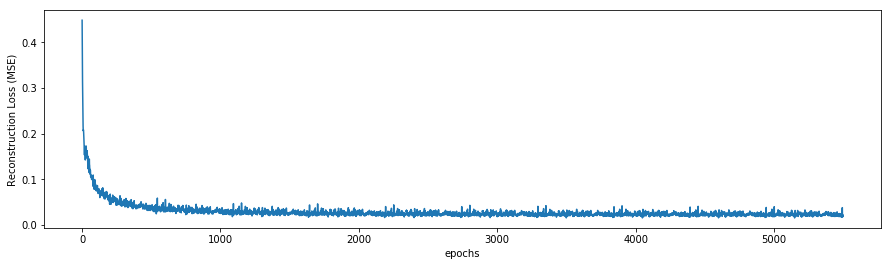

In [6]:
plt.figure(figsize=(15, 4))
plt.plot(err)
plt.xlabel('epochs')
plt.ylabel('Reconstruction Loss (MSE)')
plt.show()

6. 当将来自测试数据集中的噪声图像提供给训练好的网络时，可进行图像重构

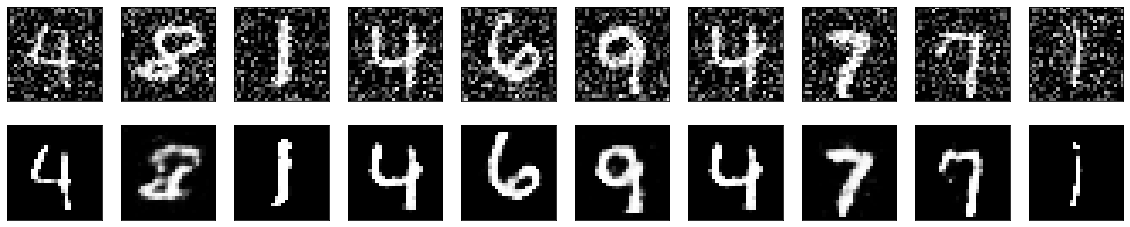

In [7]:
Xtest_noisy = corrupt_img(Xtest).astype(np.float32)
row, col = 2, 10
idx = np.random.randint(0, 100, row * col // 2)
f, axarr = plt.subplots(row, col, sharex=True, sharey=True, figsize=(20, 4))
for fig, row in zip([Xtest_noisy, out], axarr):
    for i, ax in zip(idx, row):
        ax.imshow(fig[i].reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [8]:
W1.shape, W2.shape, b1.shape, b2.shape, reduced_X.shape

((784, 800), (800, 784), (800,), (784,), (55000, 800))